# Continous Frugal Flows

In this notebook we demonstrate the ability for Frugal Flows to identify Marginal Causal Effects

In [1]:
import sys
import os
sys.path.append("../") # go to parent dir

import jax
import jax.random as jr
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import numpy as np
from scipy.stats import rankdata
import scipy.stats as ss
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import KFold

# from data.create_sim_data import *
import data.template_causl_simulations as causl_py
from data.run_all_simulations import plot_simulation_results
from frugal_flows.causal_flows import independent_continuous_marginal_flow, get_independent_quantiles, train_frugal_flow
from frugal_flows.bijections import UnivariateNormalCDF

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage

# Activate automatic conversion of rpy2 objects to pandas objects
pandas2ri.activate()

# Import the R library causl
try:
    causl = importr('causl')
except Exception as e:
    package_names = ('causl')
    utils.install_packages(StrVector(package_names))

jax.config.update("jax_enable_x64", True)

hyperparams_dict = {
    'learning_rate': 5e-3,
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 30,
    'nn_depth': 4,    
    'max_patience': 50,
    'max_epochs': 10000
}
causal_hyperparams = {
    'RQS_knots': 8,
    'flow_layers': 5,
    'nn_width': 50,
    'nn_depth': 4,   
}

SEED = 1
NUM_ITER = 20
NUM_SAMPLES = 5000
TRUE_PARAMS = {'ate': 1, 'const': 0, 'scale': 1}
CAUSAL_PARAMS = [0, 1]

In [2]:
def run_outcome_regression(data):
    df = pd.DataFrame(jnp.hstack([data['Y'], data['X']]), columns=['X', 'Y'])
    df['X'] = data['X']
    df['Y'] = data['Y']
    X_vars = df['X']
    X_vars = sm.add_constant(X_vars)
    Y_var = df['Y']
    model = sm.OLS(Y_var, X_vars).fit()
    coefficient_X = model.params['X']
    coefficient_const = model.params['const']
    return coefficient_X, coefficient_const

## Checking for the Causal Effect

### Gaussians

#### Frugal Flow

In [3]:
gaussian_covariates_results = causl_py.run_simulations(
    causl_py.generate_gaussian_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▉                                                                                                 | 90/10000 [00:20<37:54,  4.36it/s, train=-1.704351789143482, val=-1.5603401121479312 (Max patience reached)]


In [4]:
gaussian_covariates_results

,ate,const,scale
0,0.977311,0.015793,1.020034
1,1.031629,0.000757,1.012671
2,1.001076,0.011297,1.025192
3,1.018004,-0.023265,1.002134
4,0.959365,0.037451,1.015959
5,1.000670,0.014754,1.031123
6,1.004281,0.000824,1.022583
7,0.973262,0.044063,1.050398
8,0.976245,0.019859,1.036502
9,1.037978,-0.000236,0.991697


In [5]:
display(gaussian_covariates_results.mean())
display(gaussian_covariates_results.std())

ate      0.995200
const    0.014037
scale    1.022020
dtype: float64

ate      0.029638
const    0.029653
scale    0.018596
dtype: float64

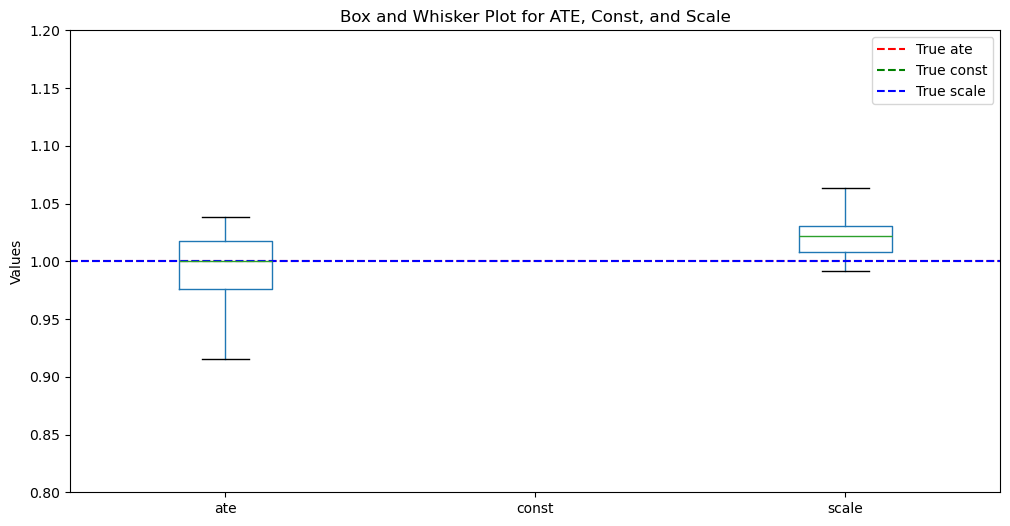

In [6]:
plt.figure(figsize=(12, 6))

# Boxplot
box = gaussian_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

#### Outcome Regression

In [7]:
gaussian_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_gaussian_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    gaussian_coeffs['ate'].append(coeff_X)
    gaussian_coeffs['const'].append(coeff_const)
gaussian_outcome_coeffs = pd.DataFrame.from_dict(gaussian_coeffs)
gaussian_outcome_coeffs

,ate,const
0,2.026113,-0.730643
1,2.044990,-0.736899
2,2.050931,-0.744995
3,2.011700,-0.704153
4,1.968978,-0.680850
5,2.039901,-0.723030
6,2.018150,-0.709956
7,1.993989,-0.689792
8,2.044761,-0.720769
9,2.034743,-0.718866


In [8]:
print(gaussian_outcome_coeffs.mean())
print(gaussian_outcome_coeffs.std())

ate      2.031246
const   -0.721153
dtype: float64
ate      0.026363
const    0.017435
dtype: float64


### Mixed Gaussian and Gamma Outcomes

In [41]:
CAUSAL_PARAMS = [0, 1]
SEED = 5
Z_d, Z_c, X, Y = causl_py.generate_mixed_samples(N=10000, causal_params=CAUSAL_PARAMS, seed=SEED).values()

uz_samples = causl_py.generate_uz_samples(Z_cont=Z_c, use_marginal_flow=False)

ff, _ = train_frugal_flow(
    key=jr.PRNGKey(123),
    y=Y,
    u_z=uz_samples['uz_cont'],
    condition=X,
    **hyperparams_dict,
    causal_model_args={'ate': 0, 'const': 1, 'scale': 1}
)

causal_margin = ff.bijection.bijections[-1].bijection.bijections[0]

print(causal_margin.ate)
print(causal_margin.const)

  1%|▊                                                                                                | 87/10000 [00:36<1:08:42,  2.40it/s, train=1.3419718091831818, val=1.4425391504285299 (Max patience reached)]

0.9683161250102058
0.03884598195762877


In [9]:
Z_disc, Z_cont, X, Y = causl_py.generate_mixed_samples(10000, CAUSAL_PARAMS, 0).values()

In [10]:
uz_samples = causl_py.generate_uz_samples(Z_cont=Z_cont, use_marginal_flow=False, seed=0, frugal_flow_hyperparams=hyperparams_dict)

In [11]:
uz_disc_samples = uz_samples['uz_disc']
uz_cont_samples = uz_samples['uz_cont']

In [12]:
frugal_flow, losses = causl_py.train_frugal_flow(
    key=jr.PRNGKey(0),
    y=Y,
    u_z=uz_cont_samples,
    condition=X,
    **hyperparams_dict,
    causal_model='gaussian',
    causal_model_args={'ate': 0., 'const': 0., 'scale': 1}
)

  1%|▋                                                                                                 | 72/10000 [00:31<1:12:17,  2.29it/s, train=1.3118372802965774, val=1.394872411050176 (Max patience reached)]


In [13]:
causal_margin = frugal_flow.bijection.bijections[-1].bijection.bijections[0]

In [14]:
causal_margin.ate

Array(0.9003078, dtype=float64)

In [15]:
causal_margin.const

Array(0.12778634, dtype=float64)

In [16]:
continous_covariates_results = causl_py.run_simulations(
    causl_py.generate_mixed_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 1., 'const': 1., 'scale': 1}
)

  1%|▌                                                                                                  | 61/10000 [00:15<42:20,  3.91it/s, train=1.2730616079737158, val=1.4790608107883358 (Max patience reached)]


In [17]:
continous_covariates_results

,ate,const,scale
0,0.539266,0.448373,1.002180
1,0.563533,0.451708,1.000141
2,0.726675,0.275943,1.021802
3,0.511131,0.480484,1.006150
4,0.522263,0.452282,1.007101
5,0.633188,0.362058,1.020287
6,0.531838,0.456988,1.030715
7,0.590012,0.401991,1.022576
8,0.528393,0.467407,1.005261
9,0.736314,0.283542,0.999010


In [18]:
print(continous_covariates_results.mean())
print(continous_covariates_results.std())

ate      0.592522
const    0.408202
scale    1.005289
dtype: float64
ate      0.077155
const    0.068645
scale    0.012702
dtype: float64


#### Outcome Regression

In [19]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_mixed_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.089497,-0.109231
1,1.177142,-0.166168
2,1.194376,-0.172352
3,1.190040,-0.173654
4,1.104726,-0.097893
5,1.075022,-0.084169
6,1.212869,-0.200547
7,1.211885,-0.211246
8,1.217704,-0.213788
9,1.305021,-0.288653


In [20]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.183109
const   -0.171733
dtype: float64
ate      0.071306
const    0.063600
dtype: float64


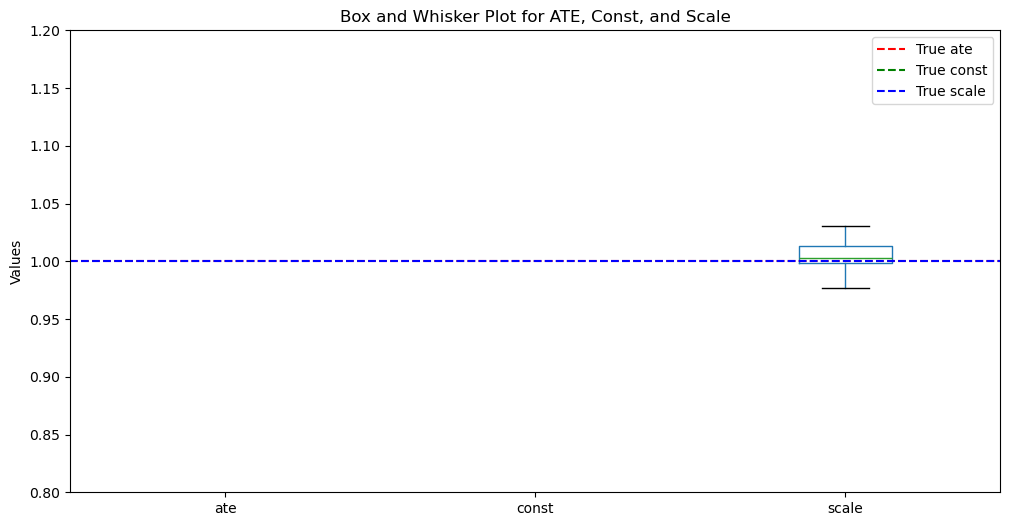

In [21]:
plt.figure(figsize=(12, 6))

# Boxplot
box = continous_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Small)

In [22]:
discrete_small_covariates_results = causl_py.run_simulations(
    causl_py.generate_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▋                                                                                                  | 65/10000 [00:15<39:25,  4.20it/s, train=1.2633254830101497, val=1.5219932682388484 (Max patience reached)]


In [23]:
discrete_small_covariates_results

,ate,const,scale
0,0.804599,0.124000,1.010999
1,0.737391,0.213184,1.025044
2,0.881302,0.062062,1.030838
3,0.988307,-0.006584,0.996006
4,1.006227,-0.031411,1.000792
5,0.969985,0.015683,1.002244
6,1.016231,-0.032012,1.003848
7,0.908297,0.069864,1.013121
8,0.703706,0.218579,1.025335
9,0.891543,0.079831,1.003292


In [24]:
print(discrete_small_covariates_results.mean())
print(discrete_small_covariates_results.std())

ate      0.926813
const    0.046289
scale    1.004246
dtype: float64
ate      0.091157
const    0.070500
scale    0.012475
dtype: float64


#### Outcome Regression

In [25]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,1.038947,-0.000549
1,1.018899,-0.026849
2,1.009400,0.019944
3,1.026105,-0.029679
4,1.017215,-0.017462
5,1.003514,-0.031213
6,1.029885,-0.018943
7,1.027318,-0.026696
8,1.056760,-0.028473
9,0.979815,0.020483


In [26]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      1.018300
const   -0.011875
dtype: float64
ate      0.026129
const    0.016899
dtype: float64


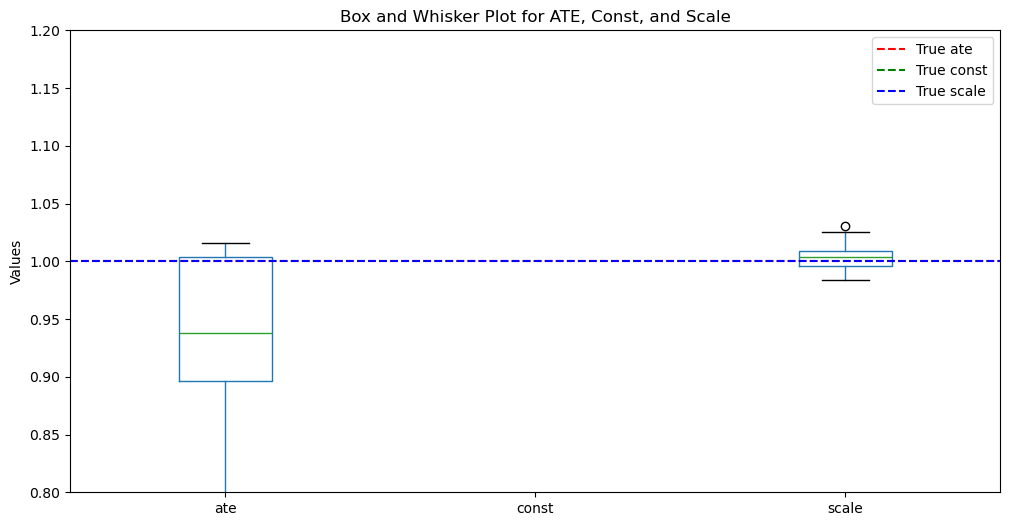

In [27]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_small_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large)

In [28]:
discrete_big_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▋                                                                                                | 67/10000 [00:28<1:10:43,  2.34it/s, train=0.4000942375558636, val=1.3414833374935642 (Max patience reached)]


In [29]:
discrete_big_covariates_results

,ate,const,scale
0,0.858034,0.057868,0.998595
1,0.864538,0.094687,1.013532
2,0.882301,0.045541,0.993757
3,0.850300,0.077872,0.990658
4,0.832598,0.095626,1.022435
5,0.890452,0.034761,1.025400
6,0.868902,0.086867,1.005728
7,0.865608,0.104203,0.991416
8,0.816678,0.111451,1.027187
9,0.863269,0.081176,0.992833


In [30]:
print(discrete_big_covariates_results.mean())
print(discrete_big_covariates_results.std())

ate      0.867739
const    0.077899
scale    1.006411
dtype: float64
ate      0.038421
const    0.024468
scale    0.010717
dtype: float64


#### Outcome Regression

In [31]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,0.937110,0.031249
1,0.886468,0.042338
2,0.888880,0.076431
3,0.879544,0.060255
4,0.856244,0.089303
5,0.899746,0.070942
6,0.942566,0.000179
7,0.920637,0.044469
8,0.906716,0.082821
9,0.898503,0.063857


In [32]:
print(outcome_coeffs.mean())
print(outcome_coeffs.std())

ate      0.895802
const    0.058493
dtype: float64
ate      0.031882
const    0.023589
dtype: float64


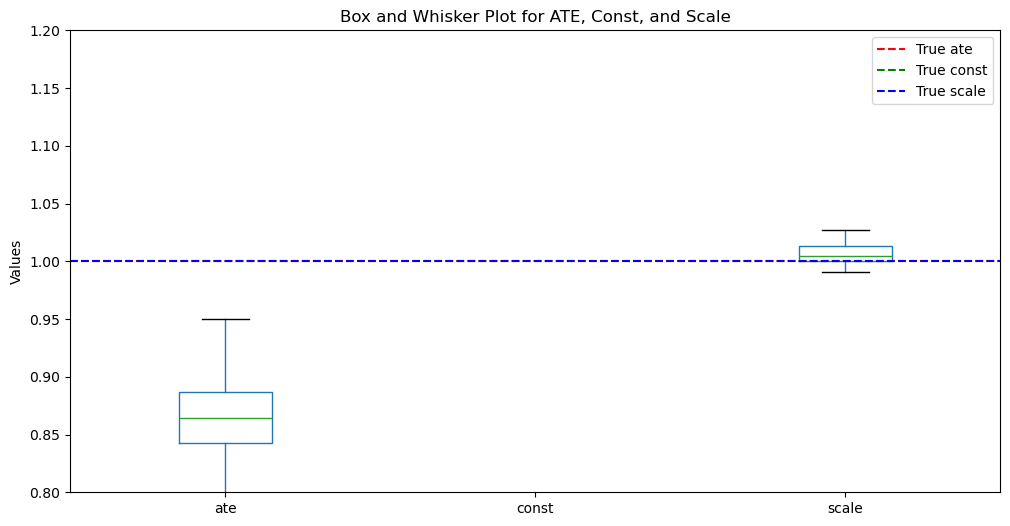

In [33]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_big_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()

### Mixed Continuous and Discrete (Large and Sparse)

In [34]:
discrete_sparse_covariates_results = causl_py.run_simulations(
    causl_py.generate_many_discrete_samples_sparse, 
    seed=SEED, 
    num_samples=NUM_SAMPLES, 
    num_iter=NUM_ITER, 
    causal_params=CAUSAL_PARAMS,
    hyperparams_dict=hyperparams_dict,
    causal_model_args={'ate': 0., 'const': 1., 'scale': 1}
)

  1%|▌                                                                                                | 60/10000 [00:25<1:09:09,  2.40it/s, train=1.1690263406591515, val=1.6519325102625213 (Max patience reached)]


In [35]:
discrete_sparse_covariates_results

,ate,const,scale
0,0.860499,0.103707,0.995415
1,0.650856,0.295604,1.012234
2,0.847159,0.115426,1.021537
3,0.719714,0.208757,1.018052
4,0.954136,0.016192,0.978177
5,0.851514,0.100923,0.998319
6,0.935909,0.061309,0.988918
7,0.951135,0.058556,0.988808
8,0.666056,0.271760,1.050866
9,0.652484,0.273513,1.034362


In [36]:
print(discrete_sparse_covariates_results.mean())
print(discrete_sparse_covariates_results.std())

ate      0.859959
const    0.103072
scale    1.005606
dtype: float64
ate      0.107302
const    0.089885
scale    0.018247
dtype: float64


#### Outcome Regression

In [37]:
outcome_coeffs = {'ate': [], 'const': []}
for i in range(NUM_ITER):
    data = causl_py.generate_many_discrete_samples(N=NUM_SAMPLES, causal_params=CAUSAL_PARAMS, seed=i)
    coeff_X, coeff_const = run_outcome_regression(data)
    outcome_coeffs['ate'].append(coeff_X)
    outcome_coeffs['const'].append(coeff_const)
outcome_coeffs = pd.DataFrame.from_dict(outcome_coeffs)
outcome_coeffs

,ate,const
0,0.937110,0.031249
1,0.886468,0.042338
2,0.888880,0.076431
3,0.879544,0.060255
4,0.856244,0.089303
5,0.899746,0.070942
6,0.942566,0.000179
7,0.920637,0.044469
8,0.906716,0.082821
9,0.898503,0.063857


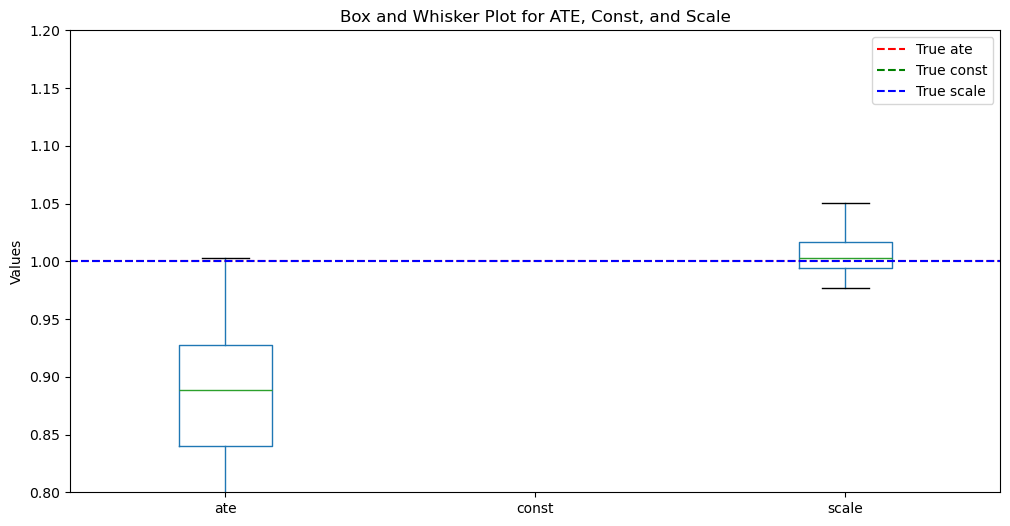

In [38]:
plt.figure(figsize=(12, 6))

# Boxplot
box = discrete_sparse_covariates_results.boxplot(column=["ate", "const", "scale"], grid=False)

# Adding lines for the true parameters
plt.axhline(y=TRUE_PARAMS['ate'], color='r', linestyle='--', label='True ate')
plt.axhline(y=TRUE_PARAMS['const'], color='g', linestyle='--', label='True const')
plt.axhline(y=TRUE_PARAMS['scale'], color='b', linestyle='--', label='True scale')

# Adding title and labels
plt.title('Box and Whisker Plot for ATE, Const, and Scale')
plt.ylabel('Values')
plt.ylim([0.80, 1.20])
plt.legend()